In [196]:
import pandas as pd
import os
import json
from typing import List
from collections import Counter
import string
import re
import nltk

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [88]:
import matplotlib.pyplot as plt
import numpy as np
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer,PorterStemmer
from nltk.tokenize import word_tokenize
from wordcloud import WordCloud, STOPWORDS
import nltk

In [6]:
! head ../../data/train.csv

meta	3	negative
@	O
AdilNisarButt	Hin
pakistan	Hin
ka	Hin
ghra	Hin
tauq	Hin
he	Eng
Pakistan	Eng
Israel	Eng


In [38]:
def parse_data(fname: str) -> pd.DataFrame:
    """
    parse the train data csv to a standard format at a tweet level.
    """
    def parse_record(rec: str) -> dict:
        """
        parse each tweet along with labels and metadata.
        """
        res = {}
        recs = rec.split("\n")
#         print(recs)
        meta, tid, sentiment = recs[0].split("\t")
        sent = []
        lang = []
        for word in recs[1:]:
            word_meta = word.split("\t")
            
            if len(word_meta)>1:
                sent.append(word_meta[0])
                lang.append(word_meta[1])
        res['id'] = tid
        res['sentiment'] = sentiment
        res['text'] = " ".join(sent)
        res['language_labels'] = lang   
        return res
    
    
    with open(fname, "r") as f:
        lines = f.readlines()

    tweets = []
    line = ""
    for w in lines:
        line += w
        if w == "\n":
            t_dict = parse_record(line)
            tweets.append(t_dict)
            # once processed. reset the tmp variable.
            line = ""

    return pd.DataFrame(tweets)

In [51]:
# df = pd.read_csv("../../data/train.csv", sep='\t')
df = parse_data("../../data/train.csv")
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15131 entries, 0 to 15130
Data columns (total 4 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   id               15131 non-null  object
 1   sentiment        15131 non-null  object
 2   text             15131 non-null  object
 3   language_labels  15131 non-null  object
dtypes: object(4)
memory usage: 473.0+ KB


In [52]:
df.head()

,id,sentiment,text,language_labels
0,3,negative,@ AdilNisarButt pakistan ka ghra tauq he Pakis...,"[O, Hin, Hin, Hin, Hin, Hin, Eng, Eng, Eng, En..."
1,41,negative,Madarchod mulle ye mathura me Nahi dikha tha j...,"[Hin, Hin, Hin, Hin, Hin, Hin, Hin, Hin, Hin, ..."
2,48,positive,@ narendramodi Manya Pradhan Mantri mahoday Sh...,"[O, Hin, Hin, Hin, Hin, Hin, Hin, Hin, Hin, Hi..."
3,64,positive,@ Atheist _ Krishna Jcb full trend me chal rah...,"[O, Eng, O, Eng, Eng, Eng, Eng, Eng, Hin, Hin,..."
4,66,positive,@ AbhisharSharma _ @ RavishKumarBlog Loksabha ...,"[O, Hin, O, O, Hin, Eng, Hin, Hin, Hin, Hin, H..."


In [264]:
# text preprocessing 

def clean_text(text: str) -> str:
#     print(text)
    text = text.lower()
    text = re.sub(r"@", "mention", text)
    text = re.sub(r"#", "hashtag", text)
    text = re.sub(r"http\S+", '', text)
    text = re.sub(r"t co \w+", '', text)
    text = re.sub('\[.*?\]', '', text)
    text = re.sub('<.*?>+', '', text)
    text = re.sub('[%s]' % re.escape(string.punctuation), '', text)
    text = re.sub('\n', '', text)
#     print(text)

    return text


def text_preprocessing(text: str) -> str:
    tokenizer = nltk.tokenize.RegexpTokenizer(r'\w+')
    nopunc = clean_text(text)
    tokenized_text = tokenizer.tokenize(nopunc)
    combined_text = ' '.join(tokenized_text)
    return combined_text

In [258]:
df['clean_text'] = df['text'].apply(str).apply(lambda x: text_preprocessing(x))

In [285]:
labels = sorted(list(df.sentiment.unique()))
labels

['negative', 'neutral', 'positive']

In [286]:
df['labels'] = df['sentiment'].apply(str).apply(lambda x: labels.index(x))

In [287]:
train_df = df.sample(frac=0.95, random_state=200)
val_df = df.drop(train_df.index)

df.shape, train_df.shape, val_df.shape

((15131, 6), (14374, 6), (757, 6))

In [288]:
df.sample(10)

,id,sentiment,text,language_labels,clean_text,labels
4833,15868,neutral,RT @ Rowdy _ jayanto Darpok o hota hai jo Eid ...,"[Eng, O, Eng, O, Hin, Hin, Hin, Hin, Hin, Hin,...",rt mention rowdy jayanto darpok o hota hai jo ...,1
9657,27178,negative,@ TajinderBagga @ MamataOfficial Sune hai bhar...,"[O, Eng, O, Eng, Hin, Hin, Hin, Hin, Hin, Hin,...",mention tajinderbagga mention mamataofficial s...,0
13444,40108,neutral,Hum Russell ky saamne let gaye agle match me A...,"[Hin, Eng, Hin, Hin, Hin, Hin, Hin, Hin, Hin, ...",hum russell ky saamne let gaye agle match me a...,1
9407,26682,negative,@ Vaishalishah23 Tu padh le anpadh kidhar likh...,"[O, Eng, Hin, Hin, Hin, Hin, Hin, Hin, Hin, Hi...",mention vaishalishah23 tu padh le anpadh kidha...,0
5598,17322,negative,@ RahulGandhi hello Mr . Who r u ??? Agar tumh...,"[O, Hin, Hin, Hin, O, Eng, Eng, Hin, O, Hin, H...",mention rahulgandhi hello mr who r u agar tumh...,0
8773,25012,negative,Tumari party Ke to netao ki roj Mar pit hoti p...,"[Hin, Hin, Hin, Hin, Hin, Hin, Hin, Hin, Hin, ...",tumari party ke to netao ki roj mar pit hoti p...,0
5644,17410,negative,@ yadavdimples @ RahulGandhi Sahi nasal ke kut...,"[O, Eng, O, Hin, Hin, Hin, Hin, Hin, Hin, Hin,...",mention yadavdimples mention rahulgandhi sahi ...,0
9806,27472,neutral,went for a 30.1 mile road ride . https // t . ...,"[Eng, Eng, Eng, O, Eng, Eng, Eng, O, Eng, O, E...",went for a 301 mile road ride t co ojoi8nebqm ...,1
10173,28309,neutral,@ anandk2012 @ RailwaySeva @ IRCTCofficial Pri...,"[O, Eng, O, Eng, O, Eng, Eng, Eng, Hin, Hin, H...",mention anandk2012 mention railwayseva mention...,1
12288,35779,positive,@ LogicalGabbar Bhai swami ji intellectual per...,"[O, Eng, Eng, Hin, Eng, Eng, Eng, Hin, O, Eng,...",mention logicalgabbar bhai swami ji intellectu...,2


In [289]:
# save data
df.to_csv("../../data/processed_data.csv", index=False)
train_df.to_csv("../../data/processed_train.csv", index=False)
val_df.to_csv("../../data/processed_val.csv", index=False)

In [267]:
with open("../../data/cleaned_tweets_language_modelling.txt", "w") as f:
    for twt in df['clean_text'].tolist():
        f.write(str(twt)+'\n')

## EDA
#### Distribution of Sentiment labels (tweet level)

<AxesSubplot:title={'center':'Distribution of Sentiment labels (tweet level)'}>

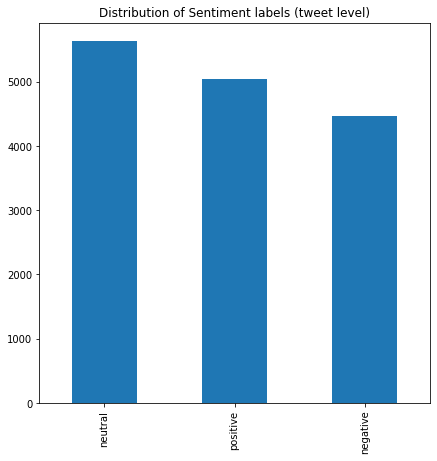

In [83]:
df.sentiment.value_counts().plot(kind='bar', title="Distribution of Sentiment labels (tweet level)", figsize=(7,7))

#### Distribution of Language labels (token level)

<AxesSubplot:title={'center':'Distribution of Language labels (token level)'}>

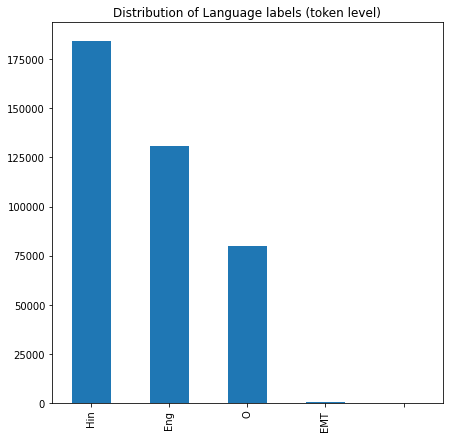

In [86]:
lang_counts = []
df.language_labels.apply(lambda z: lang_counts.extend(z))
pd.Series(lang_counts).value_counts().plot(kind='bar', title="Distribution of Language labels (token level)", figsize=(7,7))


#### Length of tweets - (No. of tokens)

<AxesSubplot:title={'center':'Length of tweets - (No. of tokens)'}, ylabel='Frequency'>

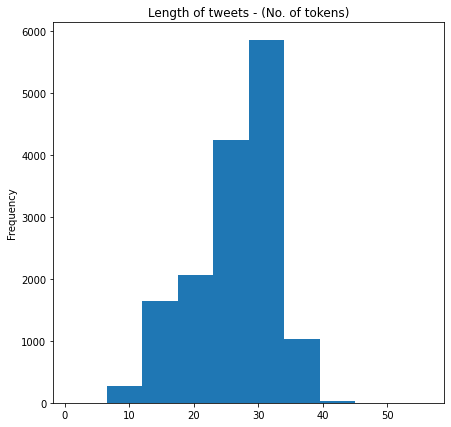

In [85]:
df.text.str.split().map(lambda x: len(x)).plot.hist(title="Length of tweets - (No. of tokens)", figsize=(7,7))

In [279]:
def plot_wordcloud(text: List[str]) -> None:
#     nltk.download('stopwords')
    stop=set(stopwords.words('english'))
    stop.add("https")
    stop.add("mention")
    stop.add("retweet")
    stop.add("hashtag")
    stop.add("co")
    stop.add("rt")
    stop.add("tco")
    for i_ in range(10):
        stop.add(str(i_))
        
    hindi_stopwords = ['ye', 'tu', 'k', 'ki', 'se', 'bhi', 'kya', 
                       'mai', 'bhi', 'kuch', 'mein', 'aur', 'ab',
                       'toh', 'ho', 'kyu', 'nahi', 'ko', 'jo',
                       'woh', 'tum', 'meri', 'teri', 'apna', 'apni',
                       'yeh', 'h', 'hai', 'hain', 'pe', 'tha', 'hai',
                       
                      ]
    with open("../../data/stop_hinglish.txt") as f:
        xx = f.readlines()
        xx = [x.strip('\n') for x in xx]
    
    hindi_stopwords.extend(xx)
    stop = stop.union(set(hindi_stopwords))
    def _preprocess_text(text):
        corpus=[]
        for tweet in text:
            words=[w.lower() for w in tweet.split() if (w.lower() not in stop and w.lower() not in string.punctuation)]
            corpus.append(words)
        return corpus
    
    corpus=_preprocess_text(text)
    
    wordcloud = WordCloud(
        background_color='white',
        stopwords=set(stop),
        max_words=100,
        max_font_size=30, 
        scale=3,
        random_state=1)
    
    wordcloud=wordcloud.generate(str(corpus))

    fig = plt.figure(1, figsize=(15, 13))
    plt.axis('off')
 
    plt.imshow(wordcloud)
    plt.show()

## Word cloud : All tweets

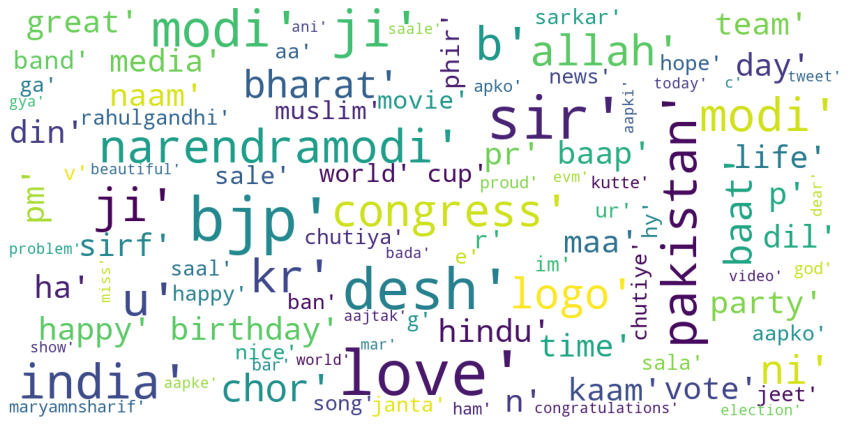

In [280]:
plot_wordcloud(df['clean_text'])

## Word cloud : Positive tweets


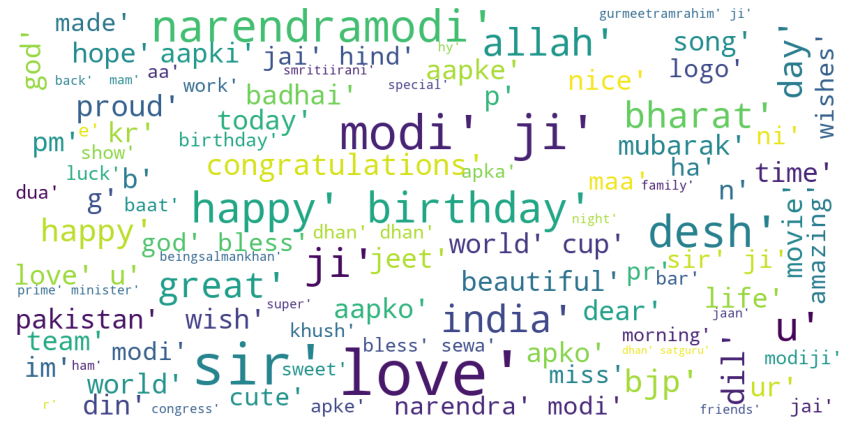

In [281]:
plot_wordcloud(df[df['sentiment']=='positive']['clean_text'])

## Word cloud : Negative tweets


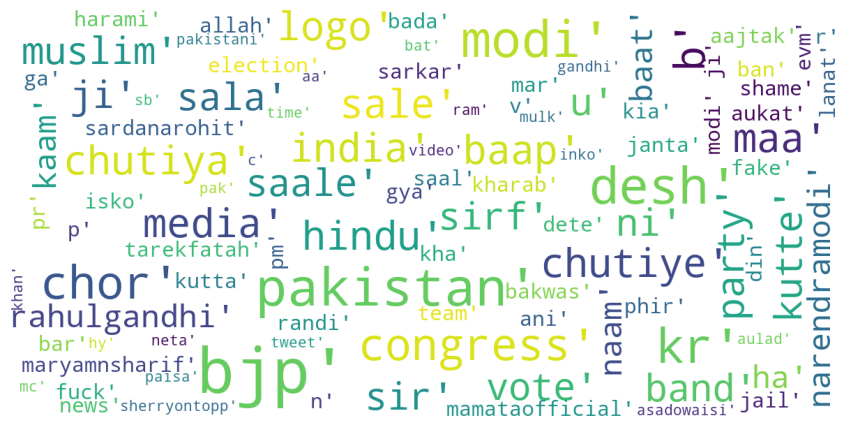

In [282]:
plot_wordcloud(df[df['sentiment']=='negative']['clean_text'])

## Word cloud : Neutral tweets


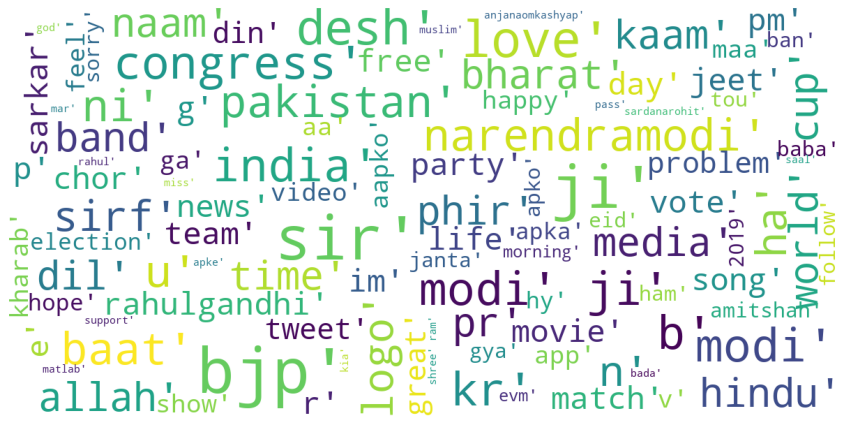

In [283]:
plot_wordcloud(df[df['sentiment']=='neutral']['clean_text'])